http://hunkim.github.io/ml/

# OpenAI Gym

In [1]:
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display

def display_frames_as_gif(frames):
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display(display_animation(anim, default_mode='once'))

In [2]:
import gym
env = gym.make('CartPole-v0')
env.reset()
done = False
frames = []
while not done:
    frames.append(env.render(mode='rgb_array'))
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    if done:
        env.render(close=True)

[2017-06-08 14:24:33,749] Making new env: CartPole-v0



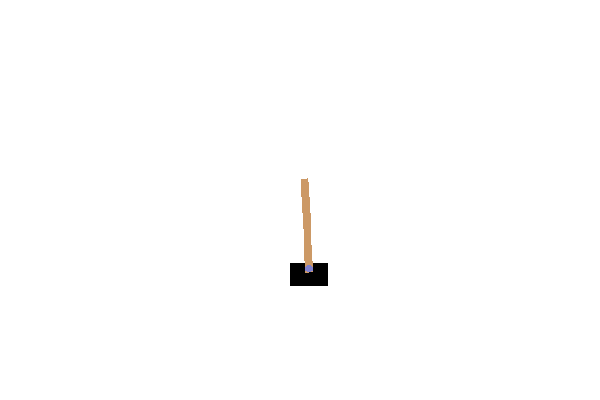
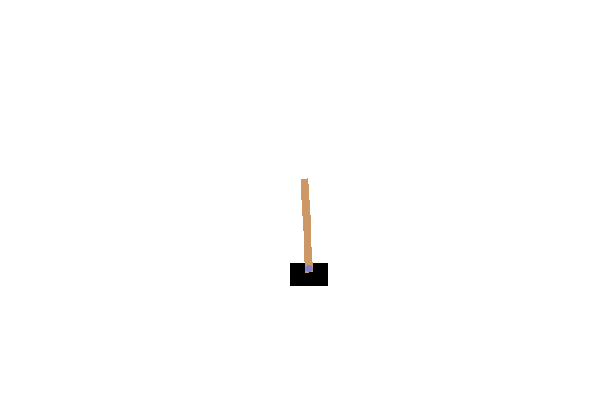
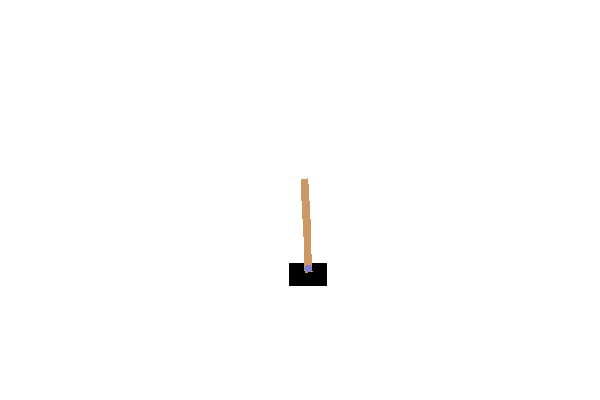
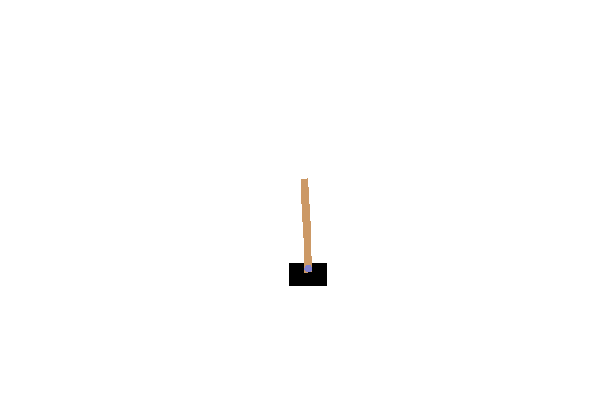
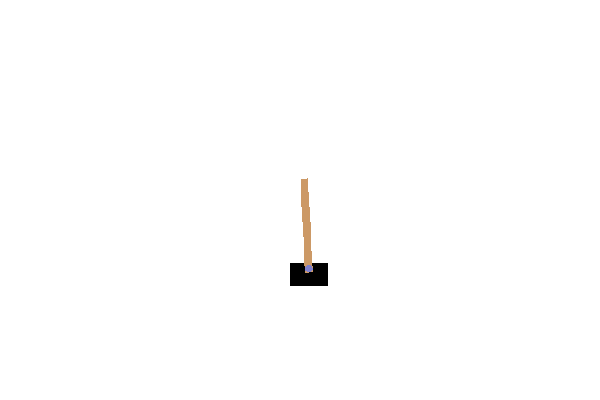
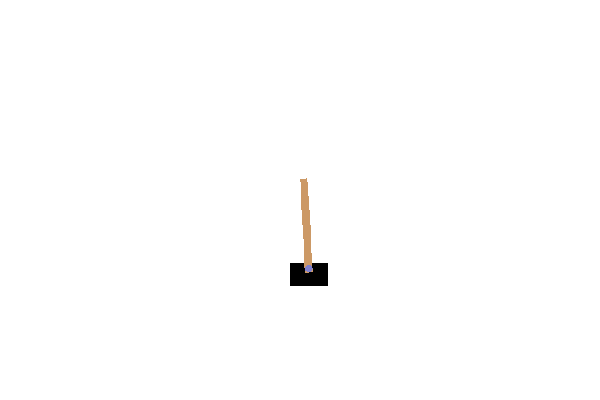
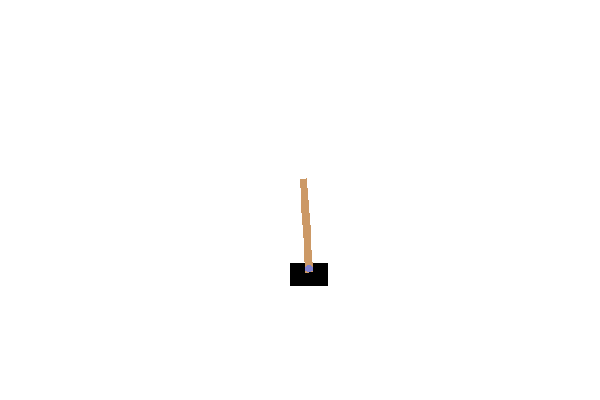
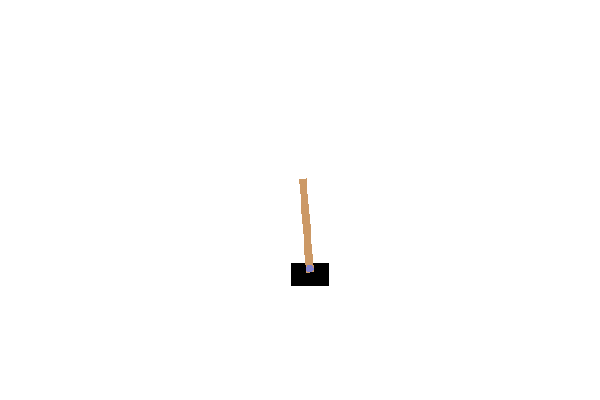
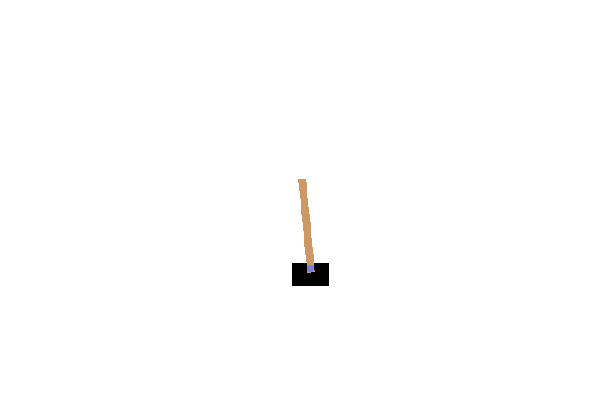
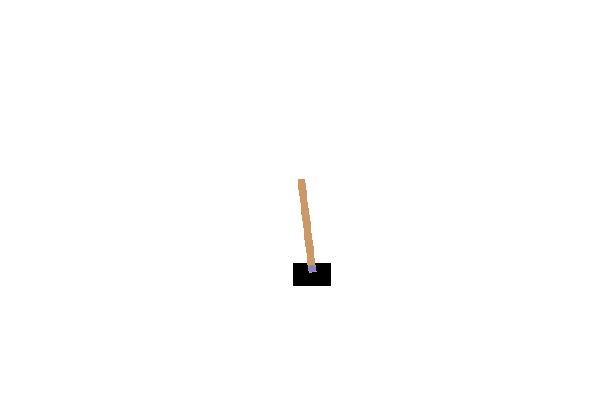
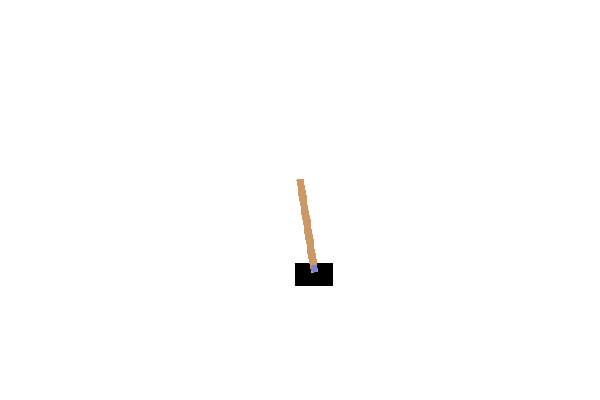
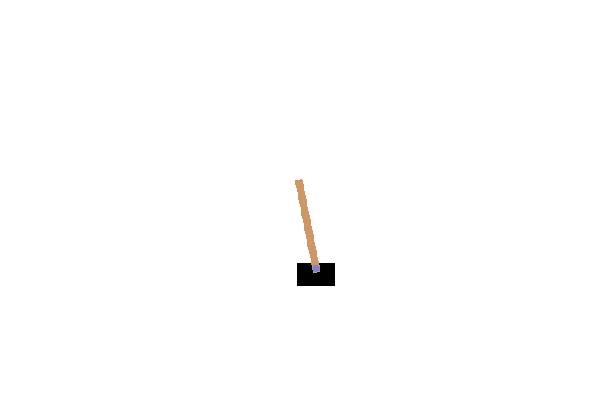

In [3]:
display_frames_as_gif(frames)

---

# Q-Learning (dummy)

- Algorithm
  1. For each $s, a$ initialize table entry $\hat{Q}(s, a) \gets 0$
  2. Do forever: 
    - Select action $a$ and execute it
    - Receive immediate reward $r$
    - Observe new state $s'$
    - Update table $\hat{Q}(s, a) \gets r + \underset{a'}\max{\hat{Q}(s', a')}$
    - $s \gets s'$
- Guarantees to converge

In [4]:
import random

import gym
from gym.envs.registration import register
import numpy as np

def rargmax(vector):
    m = np.amax(vector)
    indices = np.nonzero(vector == m)[0]
    return random.choice(indices)

In [5]:
register(
    id='FrozenLake-v3',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4', 'is_slippery': False}
)
env = gym.make('FrozenLake-v3')
Q = np.zeros([env.observation_space.n, env.action_space.n])
env.render()    # start, frozen, hole, goal

[2017-06-08 16:11:40,819] Making new env: FrozenLake-v3



SFFF
FHFH
FFFH
HFFG


In [6]:
num_episodes = 1000
for i in range(num_episodes):
    state = env.reset()
    done = False
    while not done:
        action = rargmax(Q[state, :])
        _state, reward, done, _ = env.step(action)
        Q[state, action] = reward + np.max(Q[_state, :])
        state = _state
print Q    # left, down, right, up

[[ 0.  1.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  0.]]


---

# Exploit & Exploration

- Exploit best knowledge OR Explore new action
- Decaying E-greedy: Explore less as time goes by
- Add random noise: $\text{arg}\max(\hat{Q}(s, a), \text{random_values})$

# Discounted Reward

- Q-values are all 1 above (dummy)
- $\hat{Q}$ denotes approximation of optimal $Q$
- Add discount factor $\gamma$
  - $\hat{Q}(s, a) \gets r + \gamma\underset{a'}\max{\hat{Q}(s', a')}$

# Non-deterministic

- Dummy Q-learning fails when is_slippery=True
  - Actions are non-deterministic due to wind
  - "Right" may end up "Down"
- Add learning rate $\alpha$
  - Partially trust $\hat{Q}$ function
  - $\hat{Q}(s, a) \gets (1-\alpha)\hat{Q}(s,a)+\alpha[r + \gamma\underset{a'}\max{\hat{Q}(s', a')}]$

In [7]:
env = gym.make('FrozenLake-v3')
Q = np.zeros([env.observation_space.n, env.action_space.n])
env.render()    # start, frozen, hole, goal

[2017-06-08 16:54:14,827] Making new env: FrozenLake-v3



SFFF
FHFH
FFFH
HFFG


In [8]:
num_episodes = 1000
gamma = .99    # discount
lr = .85    # learning rate
for i in range(num_episodes):
    e = 1. / ((i//100)+1)    
    state = env.reset()
    done = False
    while not done:
        # Decaying E-greedy
        #if np.random.rand(1) < e:
        #    action = env.action_space.sample()
        #else:
        #    action = np.argmax(Q[state, :])
        # Add random noise
        action = np.argmax(Q[state, :] + np.random.randn(1, env.action_space.n)/(i+1))
        _state, reward, done, _ = env.step(action)
        Q[state, action] = (1-lr)*Q[state, action] + lr*(reward + gamma * np.max(Q[_state, :]))
        state = _state
print Q

[[ 0.94148015  0.93206535  0.95099005  0.        ]
 [ 0.          0.          0.96059601  0.        ]
 [ 0.          0.970299    0.          0.96059601]
 [ 0.          0.          0.          0.        ]
 [ 0.93206535  0.78067334  0.          0.94148015]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.9801      0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.74943507  0.          0.          0.9106928 ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.99        0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.99        0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          0.        ]]


---

# DQN

- Q-learning becomes impractical when number of states is large
- Train a Network that learns to map $state \to (action, reward)$